In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
# using LaTeXStrings

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16
# rcParams["font.weight"] = "normal"

16

watch this [hilarious video](https://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) where scientists are asked to explain the p-value in one sentence. challenge yourself to explain a p-value in one sentence after going through this notebook.

# A/B testing

> In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing. The name refers to the labels of the two samples, A and B. [source](https://www.inferentialthinking.com/chapters/12/1/AB_Testing.html)

how many cauliflowers are allocated to each group?

In [2]:
df_cauli = DataFrame(
    CSV.read(
        "cauliflower.csv",
        copycols=true
    )
)

# for c in groupby(df_cauli, :group)
#     group = titlecase(c[!, :group][1])
#     num_cauli = size(c, 1)
#     println("$group group has $num_cauli cauliflowers.")
# end

by(df_cauli, :group, nb_cauli=:mass => col -> length(col))

,group,nb_cauli
,String,Int64
1,control,20
2,fertilizer,20


compare the distribution of masses among the two groups (control, treatment) in two ways:
* two opaque histograms on top of each other
* two box plots next to each other

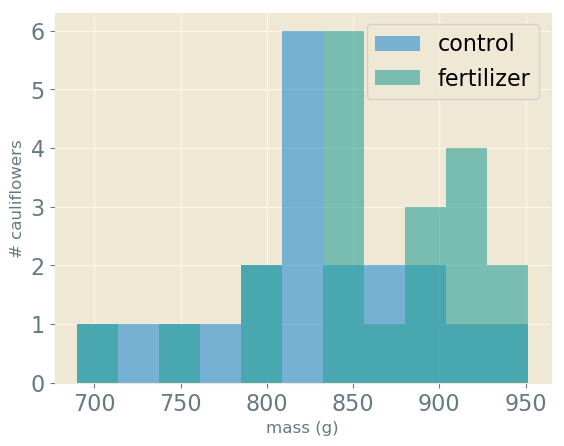

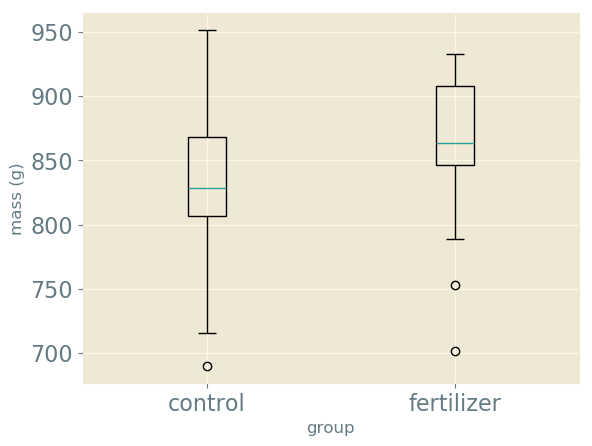

PyObject Text(25.0, 0.5, 'mass (g)')

In [3]:
###
# (1) two histograms
bins = range(
    minimum(df_cauli[!, :mass]),
    maximum(df_cauli[!, :mass]), 
    length=12
)
figure()
xlabel("mass (g)")
ylabel("# cauliflowers")
for g in groupby(df_cauli, :group)
    hist(
        g[!, :mass], 
        label=g[1, :group], 
        alpha=0.6, 
        bins=bins
    )
end
legend()

###
# (2) two boxplots
figure()
groups = ["control", "fertilizer"]
boxplot([
    filter(cauli -> cauli[:group] == group, df_cauli)[!, :mass] 
    for group in groups
])
xticks([1, 2], groups)
xlabel("group")
ylabel("mass (g)")

the distribution of masses of cauliflowers in the fertilizer group appears to be biased to the right of the distribution of masses of cauliflowers in the control group.

the average cauliflower mass in the fertilizer group is greater than the average mass in the control group.

In [4]:
by(df_cauli, :group, avg_mass=:mass => mean)

,group,avg_mass
,String,Float64
1,control,827.462
2,fertilizer,859.655


**this difference in means could be due to chance, owing to the random process of allocating the cauliflowers to the control and treatment groups!** 

**null hypothesis**: the distribution of masses among caulis treated with fertilizer is identical to that of those in the control group

**alternative hypothesis**: the distribution of masses among caulis treated with fertilizer is different than that of those in the control group

*test statistic* := (mean mass of caulis in fertilizer group) - (mean mass of caulis in the control group)

this test statistic is a random variable. if we could repeat the cauliflower experiment over and over...

## compute the test statistic
first, write a function that computes the mean mass of cauliflowers falling in a particular group ("control" or "fertilizer").

then, write a function that computes the difference in means between the two groups.

In [5]:
function μ_mass(df::DataFrame, group_col_name::Symbol, group::String)
    return mean(
        filter(
            cauli -> cauli[group_col_name] == group, df_cauli
        )[!, :mass]
    ) 
end
μ_mass(df_cauli, :group, "control")

827.4623135088772

In [6]:
for group in ["control", "fertilizer"]
    println("(mass $group cauli) = ", μ_mass(df_cauli, :group, group))
end

(mass control cauli) = 827.4623135088772
(mass fertilizer cauli) = 859.655362579846


In [7]:
function Δμ(df::DataFrame, group_col_name::Symbol)
    return μ_mass(
        df, 
        group_col_name, 
        "fertilizer"
    ) - μ_mass(
        df, 
        group_col_name, 
        "control"
    ) 
end

actual_diff_in_means = Δμ(df_cauli, :group)

32.19304907096887

## randomly permuting the group labels: simulating the test statistic under the null hypothesis
how do we simulate a repetition of this random experiment and obtain its test statistic (= difference in mean masses between fertilized and control cauli's) under the null hypothesis?


In [8]:
# we are simulating a scenario in which fetilizer does not affect the mass (null = true)
df_cauli[!, :shuffled_group] = shuffle(df_cauli[!, :group])
df_cauli

,group,mass,shuffled_group
,String,Float64,String
1,control,905.204,control
2,fertilizer,910.038,control
3,fertilizer,892.856,fertilizer
4,control,828.234,control
5,control,715.818,fertilizer
6,fertilizer,701.48,control
7,control,773.173,fertilizer
8,fertilizer,913.06,fertilizer
9,fertilizer,837.575,control


indeed, the test statistic is different (unless we happen to assing the cauliflowers to the same group, which is very unlikely).

In [9]:
new_test_statistic = Δμ(df_cauli, :shuffled_group)

-4.031638843133919

## obtain the distribution of the test statistic under the null hypothesis

let us now simulate repititions of the random experiment under the null hypothesis 10000 times, record the difference in means among the two groups, then plot the distribution of the difference in means 

In [10]:
num_sims = 10000
differences_in_means = [NaN for _ in 1:num_sims]
for i in 1:num_sims
    df_cauli[!, :shuffled_group] = shuffle(df_cauli[!, :group])
    differences_in_means[i] = Δμ(df_cauli, :shuffled_group)
end

now plot the distribution of the difference of means under the null hypothesis

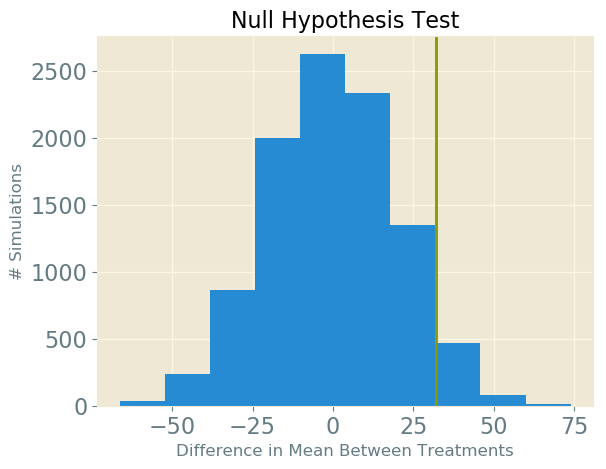

PyObject <matplotlib.lines.Line2D object at 0x7f243ed864a8>

In [11]:
hist(differences_in_means)
xlabel("Difference in Mean Between Treatments")
ylabel("# Simulations")
title("Null Hypothesis Test")
axvline(actual_diff_in_means, c="C2")

# note: our alternate hypothesis is that fertilizer strictly increases size,
# so this would be a 1 sided test

why is the difference in means centered around zero? because, under the null hypothesis, there is no difference in the mean mass between the control and treatment groups!

## compare distribution of test statistic to our observed test statistic, compute p-value



In [12]:
p_value = sum(differences_in_means .> actual_diff_in_means) / num_sims
# p value: percentage chance that the measured difference is due to chance

0.0551

the **p-value** is the proportion of simulated experiments under the null hypothesis where the difference in means was equal to or more extreme than what we observed in the actual experiment.